In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

%matplotlib inline
# sns.set_context('paper', font_scale=1.5)

import os, glob
from pathlib import Path
from scipy import stats, interpolate, signal
from scipy.signal import welch, butter, filtfilt
from nolds import sampen
from HelperFcns import *

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_context('paper', font_scale=1.5)

In [3]:
#for interactive plots
%matplotlib notebook

In [5]:
#load data
# df = pd.read_csv('c:/Users/llonini/Box/CISPD_Videos_proc/Metadata/PosesNew.csv')
df = pd.read_csv('/Users/luca/Box/CISPD_Videos_proc/Metadata/PosesNew.csv')
df.rename(columns={'Unnamed: 0':'frame#'}, inplace=True)
df.set_index(df['frame#'], inplace=True)
df.drop(['frame#'], axis=1, inplace=True)
df.head()

,SubjID,Task,cycle,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,...,midL_x,midL_y,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c,Npeople
frame#,,,,,,,,,,,,,,,,,,,,,
0,1004,FtnL,1,329.352,329.357,0.899764,360.768,385.545,0.824514,463.882,...,543.452,254.301,0.061957,540.300,256.777,0.078977,539.850,256.777,0.089969,3
1,1004,FtnL,1,329.346,328.036,0.889666,360.735,381.679,0.862279,465.103,...,539.815,254.932,0.129784,539.146,254.932,0.119539,532.907,253.149,0.160184,3
2,1004,FtnL,1,329.380,324.163,0.856091,360.758,380.347,0.878291,465.108,...,540.327,252.768,0.159085,539.872,255.268,0.124295,532.826,250.950,0.132498,3
3,1004,FtnL,1,329.406,318.941,0.898018,360.764,376.411,0.820703,465.154,...,539.706,247.097,0.259074,539.035,246.874,0.156923,537.918,246.427,0.176433,3
4,1004,FtnL,1,329.426,313.724,0.841354,360.779,371.164,0.881449,465.153,...,532.671,245.415,0.126552,531.071,245.872,0.097432,530.843,245.415,0.095396,3


In [7]:
print(len(df))
print(len(df.SubjID.unique()))
print(np.sort(df.SubjID.unique()))
print(df.Task.unique())

67875
14
[1004 1009 1019 1023 1039 1043 1044 1047 1049 1050 1052 1054 1055 1056]
['FtnL' 'FtnR' 'RamL' 'RamR' 'SitStand' 'Sitng' 'Stndg' 'Wlkg' 'Walking'
 'Drnkg']


In [161]:
df.query('SubjID==1054').Task.unique()

array(['RamL', 'RamR', 'FtnL', 'FtnR'], dtype=object)

In [5]:
tasks = ['FtnR']
scores = pd.read_csv('c:/Users/llonini/Box/CISPD_Videos_proc/Metadata/Table4.csv')
scores = scores.loc[(scores['SubjID'].isin(df.SubjID.unique())) & (scores.TaskAbb.isin(tasks))]
scores = scores[['SubjID','Visit','TaskAbb','Tremor - Left', 'Tremor - Right', 'Bradykinesia - Right', 'Bradykinesia - Left']]
scores.query('Visit != "1 Month"', inplace=True)
scores['Visit']=scores.Visit.apply(lambda x: x.split()[-1])
for i,j in enumerate(scores.Visit.unique()):
    print(i,j)
    scores.loc[scores.Visit==j, 'Visit'] = i+1
scores = scores.query('Visit ==1 | Visit ==2 | Visit==3')
scores.head(2)

0 0
1 30
2 60
3 90
4 120
5 150


,SubjID,Visit,TaskAbb,Tremor - Left,Tremor - Right,Bradykinesia - Right,Bradykinesia - Left
109,1004,1,FtnR,0.0,1.0,1.0,NaN
124,1004,2,FtnR,0.0,0.0,0.0,NaN


In [6]:
#subjects with severe symptoms
PD = scores.loc[(scores['Tremor - Left']>=2) | (scores['Tremor - Right']>=2) | 
           (scores['Bradykinesia - Left']>=2) | (scores['Bradykinesia - Right']>=2)]

noPD = scores.loc[(scores['Tremor - Left']==0) & (scores['Bradykinesia - Left']==0) | 
             (scores['Tremor - Right']==0) & (scores['Bradykinesia - Right']==0)]

PDsubj = PD.SubjID.unique()
noPDsubj = noPD.SubjID.unique()
print('high symptoms',PDsubj, '\nno symptoms',noPDsubj)

high symptoms [1043 1049 1050 1054 1055 1056] 
no symptoms [1004 1009 1019 1039 1043 1044 1047 1050 1052 1054]


In [7]:
PD.sort_values('Bradykinesia - Right', ascending=False)

,SubjID,Visit,TaskAbb,Tremor - Left,Tremor - Right,Bradykinesia - Right,Bradykinesia - Left
1669,1043,1,FtnR,2.0,1.0,3.0,NaN
1684,1043,2,FtnR,0.0,1.0,2.0,NaN
2689,1054,1,FtnR,0.0,1.0,2.0,NaN
2194,1049,1,FtnR,3.0,1.0,1.0,NaN
2779,1055,1,FtnR,1.0,2.0,1.0,NaN
2794,1055,2,FtnR,0.0,2.0,1.0,NaN
2809,1055,3,FtnR,0.0,2.0,1.0,NaN
2869,1056,1,FtnR,0.0,2.0,1.0,NaN
2884,1056,2,FtnR,2.0,2.0,1.0,NaN
2899,1056,3,FtnR,3.0,2.0,1.0,NaN


## Participants with bradykinesia 

indexL_ median confidence: 0.0179741
indexR_ median confidence: 0.157057


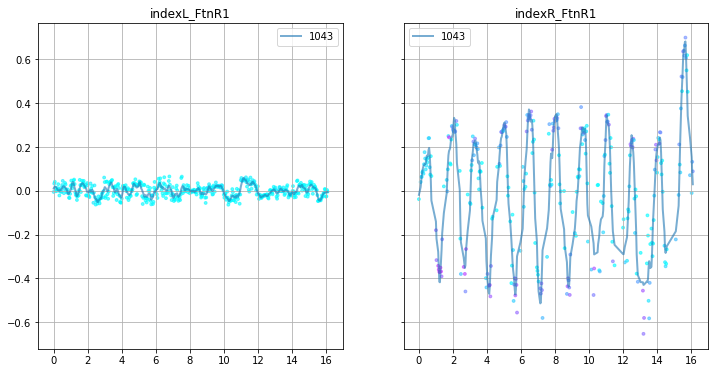

In [8]:
plot_joint_trajectory(df, subjs=['1043'], cycle=1, joint='index', colormap=True, zscore=False) #with sav-gol filter

In [139]:
# x = dist_from_ref(df, subj='1043')
# x.diff().plot(); ax=plt.title('Sample Entropy = {:.3f}'.format(sampen(x.diff().dropna())))

indexL_ median confidence: 0.8666299999999999
indexR_ median confidence: 0.696492


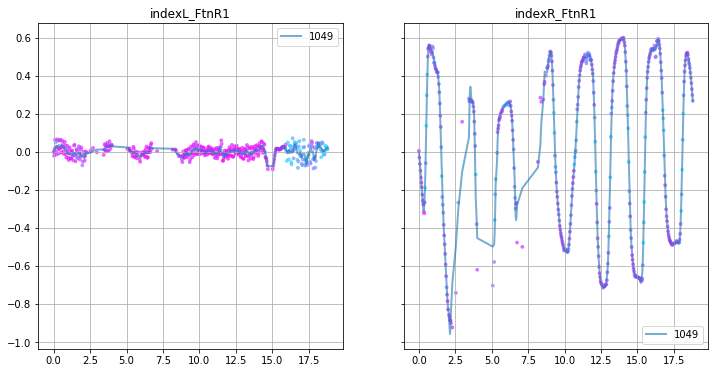

In [78]:
plot_joint_trajectory(df, subjs=['1049'], cycle=1, joint='index', colormap=True, zscore=False) #with sav-gol filter

0.005348004803240069


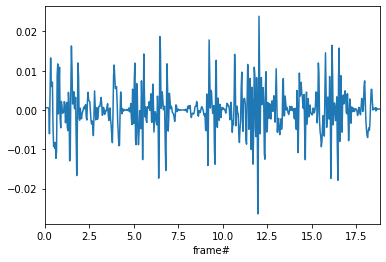

In [137]:
x = dist_from_ref(df, subj='1049')
jerk = x.diff().diff().diff();
jerk.plot()
jerk_RMS = np.sqrt((jerk**2).sum() / len(jerk))
print(jerk_RMS)

indexL_ median confidence: 0.6568055
indexR_ median confidence: 0.5217565


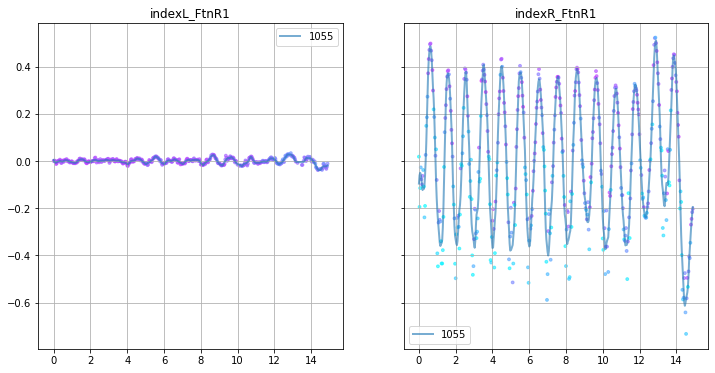

In [118]:
plot_joint_trajectory(df, subjs=['1055'], cycle=1, joint='index', colormap=True, zscore=False) #with sav-gol filter

In [140]:
# x = dist_from_ref(df, subj='1055')
# x.diff().plot(); ax=plt.title('Sample Entropy = {:.3f}'.format(sampen(x.diff().dropna())))

indexL_ median confidence: 0.38704099999999997
indexR_ median confidence: 0.28360100000000005


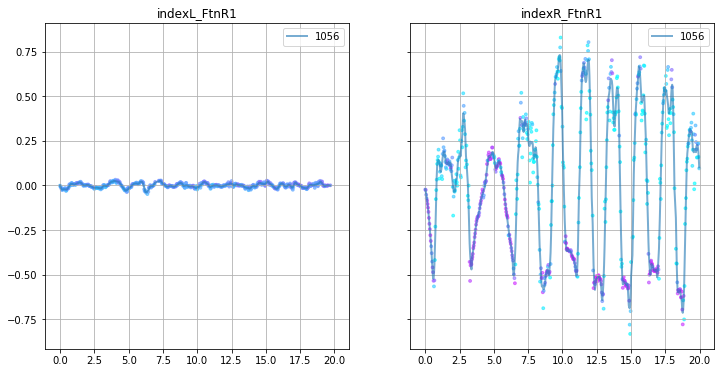

In [88]:
plot_joint_trajectory(df, subjs=['1056'], cycle=1, joint='index', colormap=True, zscore=False) #with sav-gol filter

In [141]:
# x = dist_from_ref(df, subj='1056')
# x.diff().plot(); ax=plt.title('Sample Entropy = {:.3f}'.format(sampen(x.diff().dropna())))

indexL_ median confidence: 0.752189
indexR_ median confidence: 0.231019


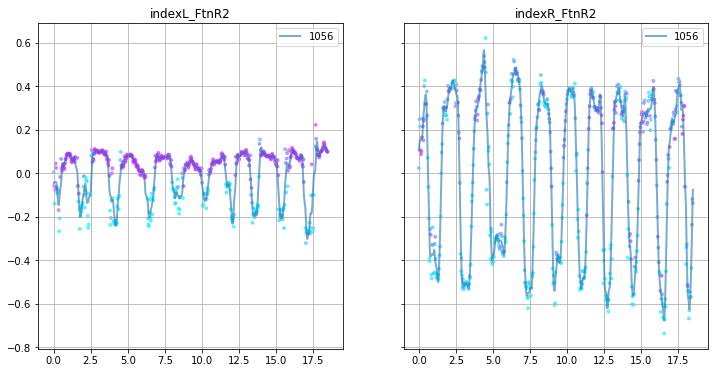

In [89]:
plot_joint_trajectory(df, subjs=['1056'], cycle=2, joint='index', colormap=True, zscore=False) #with sav-gol filter

0.017129568894494733


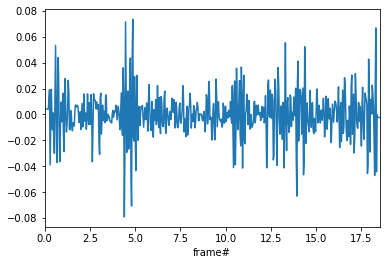

In [136]:
x = dist_from_ref(df, subj='1056',cycle=2)
jerk = x.diff().diff().diff();
jerk.plot()
jerk_RMS = np.sqrt((jerk**2).sum() / len(jerk))
print(jerk_RMS)

In [187]:
df.query('SubjID==1054').Task.unique()

array(['RamL', 'RamR', 'FtnL', 'FtnR'], dtype=object)

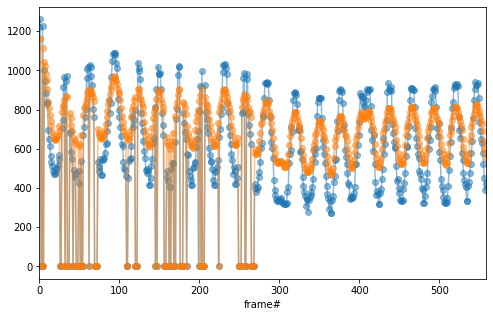

In [211]:
#example of missed detections
plt.figure(figsize=(8,5))
df.query('SubjID==1054 & Task=="FtnR" & cycle==3').indexR_x.plot(style='o-', alpha=0.5)
df.query('SubjID==1054 & Task=="FtnR" & cycle==3').wriR_x.plot(style='o-', alpha=0.5)

## Participants with no symptoms 

In [11]:
noPD

,SubjID,Visit,TaskAbb,Tremor - Left,Tremor - Right,Bradykinesia - Right,Bradykinesia - Left
124,1004,2,FtnR,0.0,0.0,0.0,NaN
139,1004,3,FtnR,0.0,0.0,0.0,NaN
439,1009,3,FtnR,0.0,0.0,0.0,NaN
724,1019,1,FtnR,0.0,0.0,0.0,NaN
754,1019,3,FtnR,0.0,0.0,0.0,NaN
1579,1039,2,FtnR,0.0,0.0,0.0,NaN
1594,1039,3,FtnR,0.0,0.0,0.0,NaN
1699,1043,3,FtnR,0.0,0.0,0.0,NaN
1774,1044,1,FtnR,0.0,0.0,0.0,NaN
1789,1044,2,FtnR,0.0,0.0,0.0,NaN


indexL_ median confidence: 0.8242925000000001
indexR_ median confidence: 0.220331


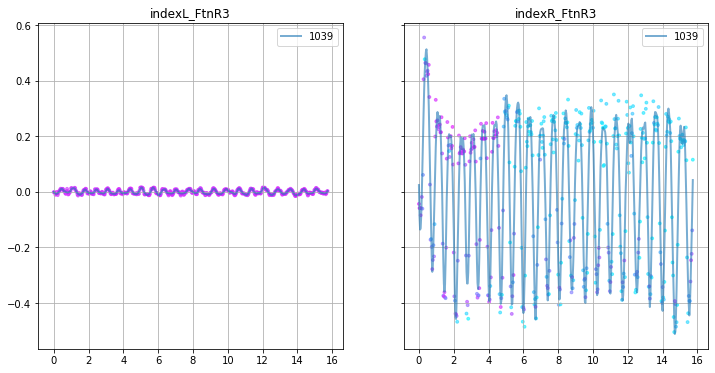

In [105]:
plot_joint_trajectory(df, subjs=['1039'], cycle=3, joint='index', colormap=True, zscore=False) #with sav-gol filter

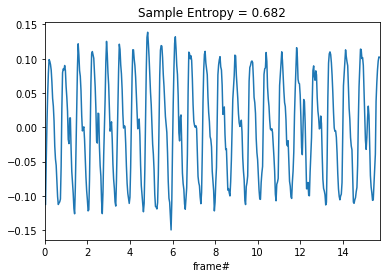

In [67]:
x = dist_from_ref(df, subj='1039', cycle=3)
x.diff().plot(); ax=plt.title('Sample Entropy = {:.3f}'.format(sampen(x.diff().dropna())))

indexL_ median confidence: 0.788911
indexR_ median confidence: 0.293722


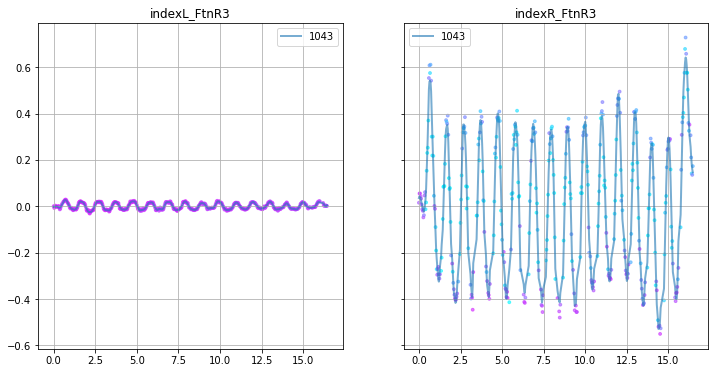

In [124]:
plot_joint_trajectory(df, subjs=['1043'], cycle=3, joint='index', colormap=True, zscore=False) #with sav-gol filter

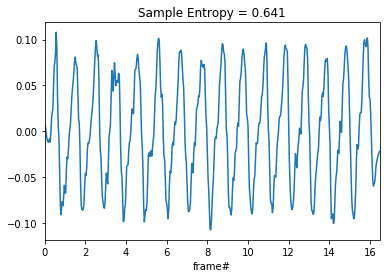

In [68]:
x = dist_from_ref(df, subj='1043', cycle=3)
x.diff().plot(); ax=plt.title('Sample Entropy = {:.3f}'.format(sampen(x.diff().dropna())))

indexL_ median confidence: 0.8443775
indexR_ median confidence: 0.790101


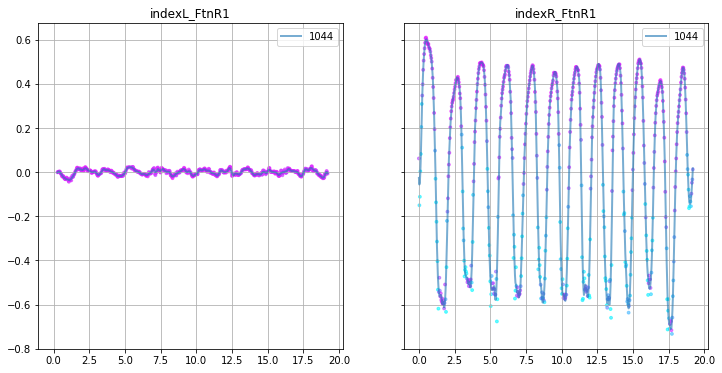

In [162]:
plot_joint_trajectory(df, subjs=['1044'], cycle=1, joint='index', colormap=True, zscore=False) #with sav-gol filter

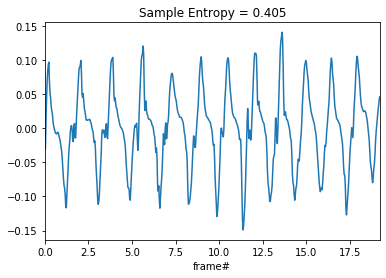

In [83]:
x = dist_from_ref(df, subj='1044', cycle=1)
x.diff().plot(); ax=plt.title('Sample Entropy = {:.3f}'.format(sampen(x.diff().dropna(), 30)))

indexL_ median confidence: 0.9234225
indexR_ median confidence: 0.141923


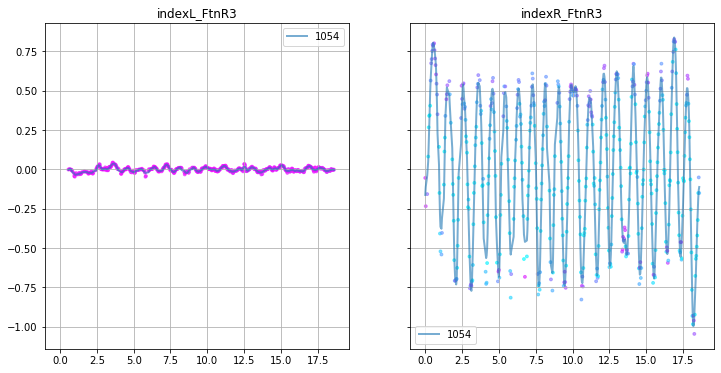

In [164]:
plot_joint_trajectory(df, subjs=['1054'], cycle=3, joint='index', colormap=True, zscore=False) #with sav-gol filter

0.015140031673216843


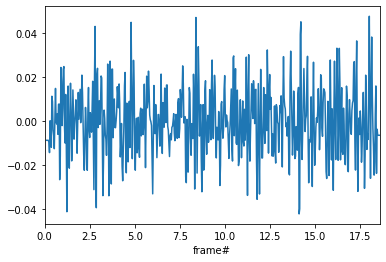

In [127]:
x = dist_from_ref(df, subj='1054', cycle=3)
jerk = x.diff().diff().diff();
jerk.plot()
jerk_RMS = np.sqrt((jerk**2).sum() / len(jerk))
print(jerk_RMS)

## Compute features on selected subjects 

In [8]:
subj = [1043, 1049, 1056, 1056, 1055, 1055, 1039, 1043, 1044, 1044, 1054]
cycle = [1, 1, 1, 2, 1, 3, 3, 3, 1, 3, 3]
scores_ = pd.DataFrame(data=[], columns = scores.columns)
for s,c in zip(subj,cycle):
    scores_ = pd.concat((scores_,scores.query('SubjID==@s & Visit==@c')),axis=0)

In [9]:
scores_

,SubjID,Visit,TaskAbb,Tremor - Left,Tremor - Right,Bradykinesia - Right,Bradykinesia - Left
1669,1043,1,FtnR,2.0,1.0,3.0,NaN
2194,1049,1,FtnR,3.0,1.0,1.0,NaN
2869,1056,1,FtnR,0.0,2.0,1.0,NaN
2884,1056,2,FtnR,2.0,2.0,1.0,NaN
2779,1055,1,FtnR,1.0,2.0,1.0,NaN
2809,1055,3,FtnR,0.0,2.0,1.0,NaN
1594,1039,3,FtnR,0.0,0.0,0.0,NaN
1699,1043,3,FtnR,0.0,0.0,0.0,NaN
1774,1044,1,FtnR,0.0,0.0,0.0,NaN
1804,1044,3,FtnR,0.0,0.0,0.0,NaN


In [10]:
F_all = pd.DataFrame()
for subj, cycle in (scores_[['SubjID','Visit']].values).tolist():
    print(subj,cycle)
    #compute distance from body landmark
    x = dist_from_ref(df, subj, cycle=cycle)
    if x is not None:
        F = compute_features_oneside(x, winlen=5, overlap=0.5)
        #merge scores with features table
        sdf = scores_.query('SubjID==@subj & Visit==@cycle')
        F['SubjID'] = subj 
        F['Tremor'] = sdf['Tremor - Right'].values[-1]
        F['Bradykinesia'] = sdf['Bradykinesia - Right'].values[-1]      
        F_all = pd.concat((F_all, F),axis=0)    

1043 1
1049 1
1056 1
1056 2
1055 1
1055 3
1039 3
1043 3
1044 1
1044 3
1054 3


In [11]:
F_all.loc[F_all.Bradykinesia > 0, 'Bradykinesia'] = 1 

In [12]:
F_all.head()

,F_dom,F_dom_ratio,spd_var,jerk_RMS,SubjID,Tremor,Bradykinesia
2.5,0.794702,0.427829,0.036866,0.011650,1043,1.0,1.0
5.0,0.596026,0.595647,0.042824,0.017334,1043,1.0,1.0
7.5,0.596026,0.559692,0.048477,0.018047,1043,1.0,1.0
10.0,0.596026,0.426556,0.046991,0.017329,1043,1.0,1.0
12.5,0.596026,0.352940,0.045005,0.019027,1043,1.0,1.0


In [26]:
F_all['motor_state'] = 'ON'
F_all.loc[F_all.Bradykinesia>0,'motor_state'] = 'OFF'

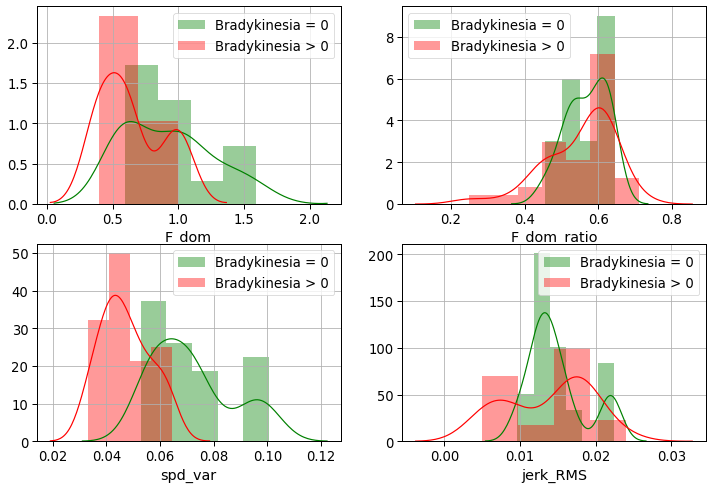

In [27]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.ravel()
for i,c in enumerate(F_all.columns[:4]):
    Fneg = F_all[F_all.Bradykinesia == 0].copy()
    Fpos = F_all[F_all.Bradykinesia > 0].copy()
    sns.distplot(Fneg[c],ax=ax[i], color='g')
    sns.distplot(Fpos[c],ax=ax[i], color='r')
    ax[i].legend(['Bradykinesia = 0', 'Bradykinesia > 0'])
    ax[i].grid()

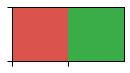

In [22]:
colors = ['pale red','medium green']
sns.palplot(sns.xkcd_palette(colors))

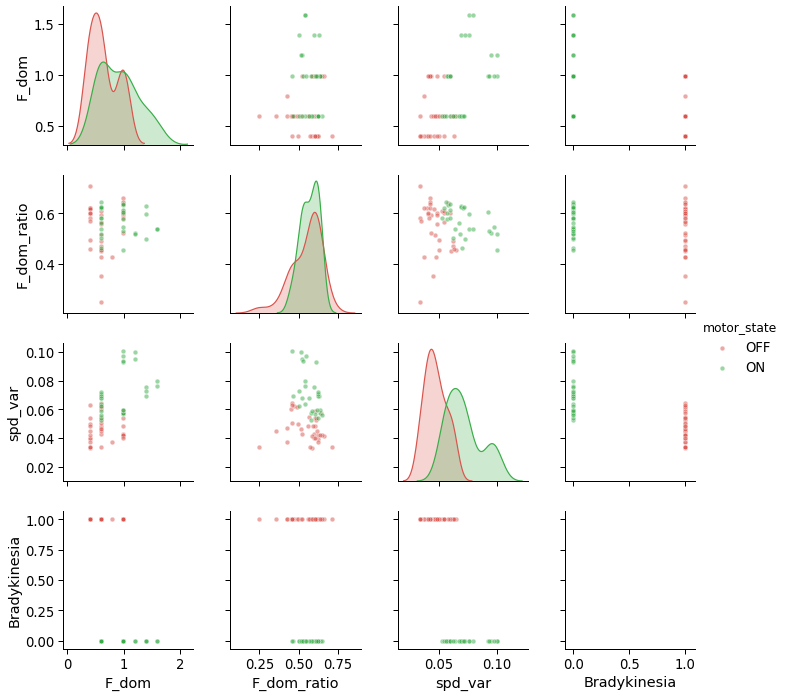

In [28]:
sns.pairplot(F_all.drop(labels=['SubjID', 'Tremor', 'jerk_RMS'],axis=1), hue='motor_state', plot_kws=dict(alpha=0.5),
             palette=sns.xkcd_palette(colors))

## Poor detection examples

Challenges are:
* There is no way to tell whetehr the detection is good or bad (median confidence is similar for both cases)
* We do not have clean videos for many patients
* Scores are noisy


wriL_ median confidence: 0.233451
wriR_ median confidence: 0.78289


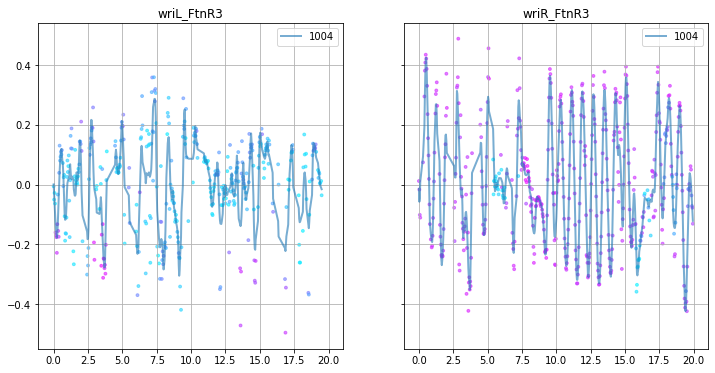

In [94]:
plot_joint_trajectory(df, subjs=['1004'], cycle=3, joint='wri', colormap=True, zscore=False) #with sav-gol filter

wriL_ median confidence: 0.77605
wriR_ median confidence: 0.8182020000000001


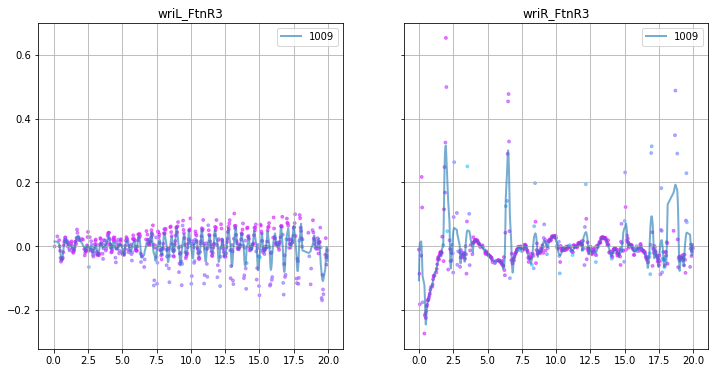

In [212]:
plot_joint_trajectory(df, subjs=['1009'], cycle=3, joint='wri', colormap=True, zscore=False) #with sav-gol filter

indexL_ median confidence: 0.28542999999999996
indexR_ median confidence: 0.23176599999999997


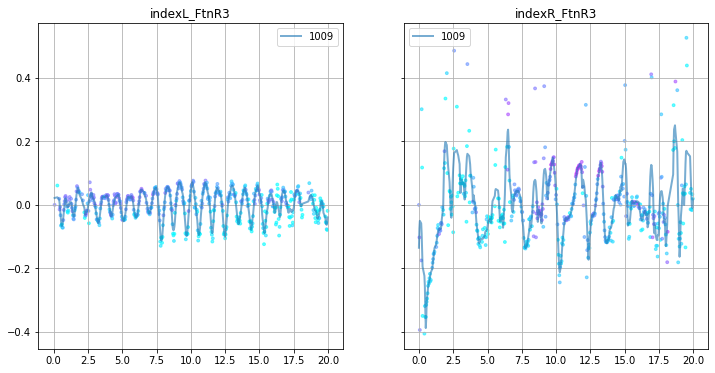

In [120]:
plot_joint_trajectory(df, subjs=['1009'], cycle=3, joint='index', colormap=True, zscore=False) #with sav-gol filter

elbL_ median confidence: 0.763484
elbR_ median confidence: 0.730625


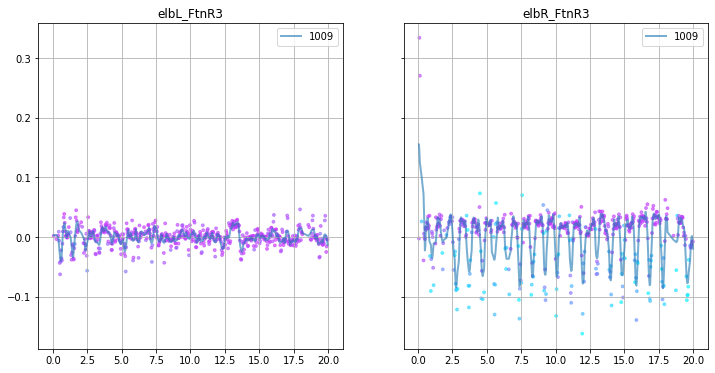

In [31]:
plot_joint_trajectory(df, subjs=['1009'], cycle=3, joint='elb', colormap=True, zscore=False) #with sav-gol filter

indexL_ median confidence: 0.788911
indexR_ median confidence: 0.293722


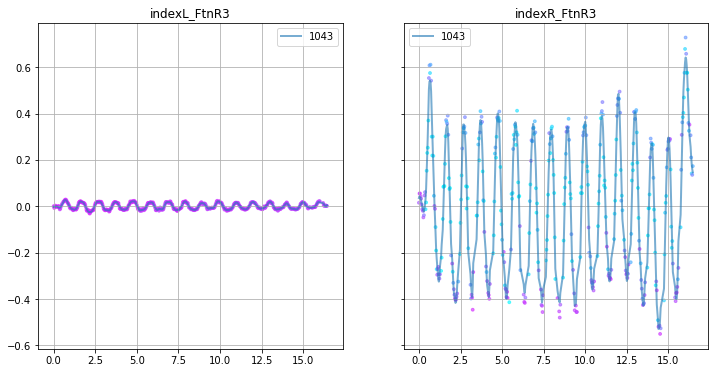

In [19]:
plot_joint_trajectory(df, subjs=['1043'], cycle=3, joint='index', colormap=True, zscore=False) #with sav-gol filter

In [460]:
#no symptoms right side
tasksR = ['RamR']
nobradyR=scores.loc[(scores['TaskAbb'].isin(tasksR)) & (scores['Bradykinesia - Right']<1) &
          (scores['Tremor - Right']<1) & (scores['Tremor - Left'] < 1)].copy()
nobradyR['symptom'] = 0
nobradyR.SubjID.unique()

array([1004, 1019, 1023, 1039, 1043, 1044, 1054], dtype=int64)

In [461]:
#bradkinesia in right side 
bradyR = scores.loc[(scores['Bradykinesia - Right']>=1) & (scores['TaskAbb'].isin(tasksR))].copy()
bradyR['symptom'] = 1
# bradyR.SubjID.unique()
bradyR.sort_values('Bradykinesia - Right', ascending = False).iloc[:10,:]

,SubjID,Visit,TaskAbb,Tremor - Left,Tremor - Right,Bradykinesia - Right,Bradykinesia - Left,symptom
1672,1043,1,RamR,2.0,2.0,3.0,NaN,1
2902,1056,3,RamR,3.0,2.0,2.0,NaN,1
2887,1056,2,RamR,1.0,2.0,2.0,NaN,1
2872,1056,1,RamR,2.0,1.0,2.0,NaN,1
2692,1054,1,RamR,0.0,0.0,2.0,NaN,1
1687,1043,2,RamR,1.0,1.0,2.0,NaN,1
412,1009,1,RamR,1.0,0.0,2.0,NaN,1
2512,1052,1,RamR,0.0,1.0,2.0,NaN,1
2227,1049,3,RamR,1.0,0.0,1.0,NaN,1
2722,1054,3,RamR,0.0,0.0,1.0,NaN,1


In [49]:
nobradyR.sort_values('Bradykinesia - Right').iloc[:10,:]

,SubjID,Visit,TaskAbb,Tremor - Left,Tremor - Right,Bradykinesia - Right,Bradykinesia - Left,symptom
124,1004,2,FtnR,0.0,0.0,0.0,NaN,0
139,1004,3,FtnR,0.0,0.0,0.0,NaN,0
439,1009,3,FtnR,0.0,0.0,0.0,NaN,0
724,1019,1,FtnR,0.0,0.0,0.0,NaN,0
754,1019,3,FtnR,0.0,0.0,0.0,NaN,0
1579,1039,2,FtnR,0.0,0.0,0.0,NaN,0
1594,1039,3,FtnR,0.0,0.0,0.0,NaN,0
1699,1043,3,FtnR,0.0,0.0,0.0,NaN,0
1774,1044,1,FtnR,0.0,0.0,0.0,NaN,0
1789,1044,2,FtnR,0.0,0.0,0.0,NaN,0


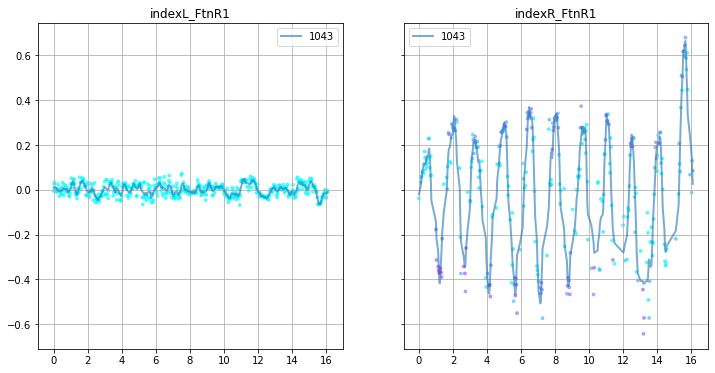

In [392]:
plot_joint_trajectory(df, subjs=['1043'], cycle=1, joint='index', colormap=True, zscore=False) #with sav-gol filter

In [445]:
task = 'RamR'
subj = 1043
cycle = 1
# data = df.query('SubjID == @subj & Task==@task & cycle==@cycle').copy()
# dist_from_ref(data,'index')
x = dist_from_ref(df, subj=subj, cycle=cycle, task=task, joint='index')

In [452]:
F = compute_features_oneside(x, winlen=4, overlap=0.9)

(0, 3)

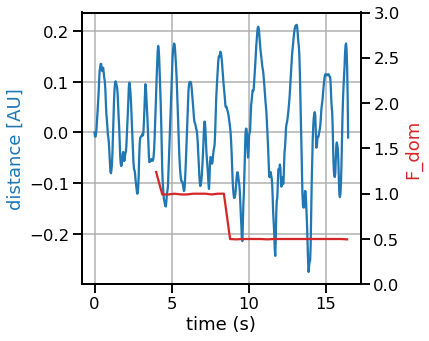

In [453]:
sns.set_context('talk', font_scale=1)
fig, ax1 = plt.subplots(figsize=(5,5))
color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('distance [AU]', color=color)
ax1.plot(x.index, x, color=color)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('F_dom', color=color)  # we already handled the x-label with ax1
ax2.plot(F.index, F.F_dom, color=color)
ax2.set_ylim([0,3])


In [249]:
compute_features(x)

,F_dom,F_dom_ratio,entropy_psd,RMS
0,0.681818,0.431134,2.308813,0.234416


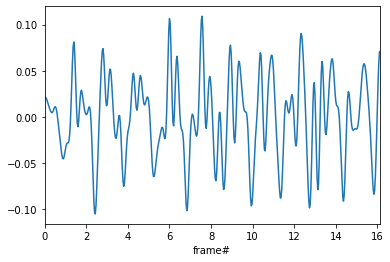

In [244]:
x.diff().plot()

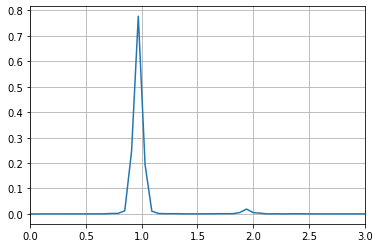

In [233]:
f, Pxx_den = welch(x, fs=30, nperseg=min(len(x),512))
plt.plot(f,Pxx_den)
plt.xlim([0,3])
plt.grid()

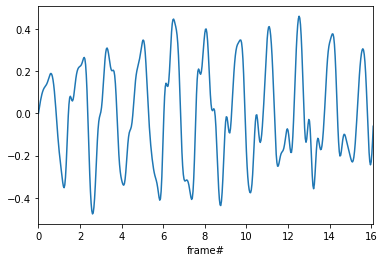

In [245]:
x.plot()

526
556


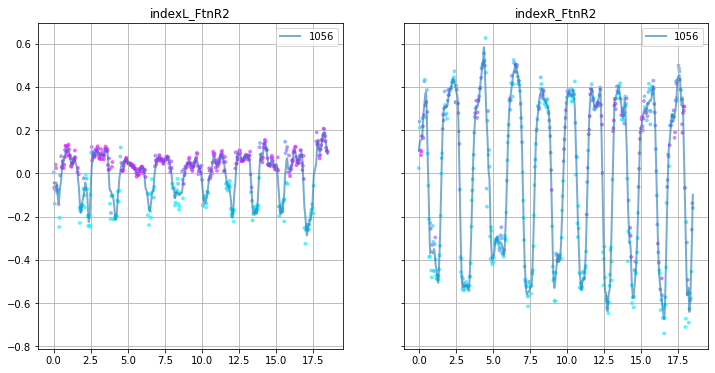

In [182]:
plot_joint_trajectory(df, subjs=['1056'], cycle=2, joint='index', colormap=True, zscore=False) #band pass filter only 0.5-3

In [70]:
df.head()

,SubjID,Task,cycle,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,...,midL_x,midL_y,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c,Npeople
frame#,,,,,,,,,,,,,,,,,,,,,
0,1004,FtnL,1,329.352,329.357,0.899764,360.768,385.545,0.824514,463.882,...,543.452,254.301,0.061957,540.300,256.777,0.078977,539.850,256.777,0.089969,3
1,1004,FtnL,1,329.346,328.036,0.889666,360.735,381.679,0.862279,465.103,...,539.815,254.932,0.129784,539.146,254.932,0.119539,532.907,253.149,0.160184,3
2,1004,FtnL,1,329.380,324.163,0.856091,360.758,380.347,0.878291,465.108,...,540.327,252.768,0.159085,539.872,255.268,0.124295,532.826,250.950,0.132498,3
3,1004,FtnL,1,329.406,318.941,0.898018,360.764,376.411,0.820703,465.154,...,539.706,247.097,0.259074,539.035,246.874,0.156923,537.918,246.427,0.176433,3
4,1004,FtnL,1,329.426,313.724,0.841354,360.779,371.164,0.881449,465.153,...,532.671,245.415,0.126552,531.071,245.872,0.097432,530.843,245.415,0.095396,3


In [75]:
df.columns

Index(['SubjID', 'Task', 'cycle', 'elbR_x', 'elbR_y', 'elbR_c', 'wriR_x',
       'wriR_y', 'wriR_c', 'elbL_x', 'elbL_y', 'elbL_c', 'wriL_x', 'wriL_y',
       'wriL_c', 'nose_x', 'nose_y', 'nose_c', 'neck_x', 'neck_y', 'neck_c',
       'midHip_x', 'midHip_y', 'midHip_c', 'thumbR_x', 'thumbR_y', 'thumbR_c',
       'indexR_x', 'indexR_y', 'indexR_c', 'midR_x', 'midR_y', 'midR_c',
       'ringR_x', 'ringR_y', 'ringR_c', 'pinkyR_x', 'pinkyR_y', 'pinkyR_c',
       'thumbL_x', 'thumbL_y', 'thumbL_c', 'indexL_x', 'indexL_y', 'indexL_c',
       'midL_x', 'midL_y', 'midL_c', 'ringL_x', 'ringL_y', 'ringL_c',
       'pinkyL_x', 'pinkyL_y', 'pinkyL_c', 'Npeople'],
      dtype='object')

In [97]:
df[cols].apply(removeOutliersb)

,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,elbL_y,elbL_c,wriL_x,...,indexL_c,midL_x,midL_y,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c
frame#,,,,,,,,,,,,,,,,,,,,,
0,-0.915296,-0.600305,1.016480,-0.908644,-0.338741,0.723628,-1.121390,-0.916836,0.735538,-0.835461,...,-1.087418,-0.656022,-0.823828,-1.044647,-0.675110,-0.829698,-0.916700,-0.693839,-0.836486,-0.869046
1,-0.915319,-0.606501,0.964050,-0.908761,-0.353935,0.909320,-1.117672,-0.936638,0.784636,-0.831680,...,-1.180335,-0.666436,-0.821643,-0.827696,-0.678406,-0.836147,-0.780650,-0.713634,-0.849190,-0.629415
2,-0.915192,-0.624665,0.789722,-0.908680,-0.359171,0.988051,-1.117657,-0.943363,0.863692,-0.835407,...,-1.025872,-0.664970,-0.829137,-0.733973,-0.676332,-0.834973,-0.764698,-0.713865,-0.856890,-0.723903
3,-0.915094,-0.649157,1.007415,-0.908659,-0.374641,0.704889,-1.117517,-0.950058,1.073248,-0.835539,...,-0.024377,-0.666748,-0.848776,-0.414147,-0.678723,-0.864314,-0.655259,-0.699347,-0.872728,-0.573960
4,-0.915020,-0.673624,0.713205,-0.908605,-0.395263,1.003579,-1.117520,-0.956819,1.032639,-0.839474,...,-1.062269,-0.686891,-0.854601,-0.838034,-0.701471,-0.867816,-0.854799,-0.719519,-0.876272,-0.850524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,1.607152,0.493933,-0.230006,0.379303,-1.854076,-1.981349,0.093719,-1.492717,-1.809007,-0.217861,...,-1.281226,-0.456914,-0.790078,-0.989819,-0.458168,-0.790604,-0.934626,-0.407216,-0.772204,-0.908824
690,1.607152,0.493933,-0.230006,0.379303,-1.854076,-1.981349,0.102727,-1.507768,-1.811547,-0.209212,...,-0.618460,-0.478409,-0.800861,0.433743,-0.487045,-0.833585,-0.314195,-0.506715,-0.898027,0.121363
691,1.607152,0.493933,-0.230006,0.379303,-1.854076,-1.981349,0.093695,-1.522891,-1.814088,-0.226690,...,-1.189483,-0.390870,-0.798520,-0.601307,-0.494957,-0.838196,0.394610,-0.512737,-0.911127,0.700500


In [98]:
df[cols]

,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,elbL_y,elbL_c,wriL_x,...,indexL_c,midL_x,midL_y,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c
frame#,,,,,,,,,,,,,,,,,,,,,
0,329.352,329.357,0.899764,360.768,385.545,0.824514,463.882,262.809,0.822884,506.948,...,0.093997,543.452,254.301,0.061957,540.300,256.777,0.078977,539.850,256.777,0.089969
1,329.346,328.036,0.889666,360.735,381.679,0.862279,465.103,258.949,0.833306,508.208,...,0.064129,539.815,254.932,0.129784,539.146,254.932,0.119539,532.907,253.149,0.160184
2,329.380,324.163,0.856091,360.758,380.347,0.878291,465.108,257.638,0.850087,506.966,...,0.113782,540.327,252.768,0.159085,539.872,255.268,0.124295,532.826,250.950,0.132498
3,329.406,318.941,0.898018,360.764,376.411,0.820703,465.154,256.333,0.894569,506.922,...,0.435721,539.706,247.097,0.259074,539.035,246.874,0.156923,537.918,246.427,0.176433
4,329.426,313.724,0.841354,360.779,371.164,0.881449,465.153,255.015,0.885949,505.611,...,0.102082,532.671,245.415,0.126552,531.071,245.872,0.097432,530.843,245.415,0.095396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,0.000,0.000,0.000000,0.000,0.000,0.000000,862.880,150.550,0.205570,712.752,...,0.031696,612.990,264.047,0.079099,616.251,267.961,0.073633,640.382,275.135,0.078314
690,0.000,0.000,0.000000,0.000,0.000,0.000000,865.838,147.616,0.194053,715.634,...,0.244748,605.483,260.933,0.524154,606.141,255.665,0.258608,605.483,239.202,0.380171
691,0.000,0.000,0.000000,0.000,0.000,0.000000,862.872,144.668,0.194090,709.810,...,0.061188,636.056,261.609,0.200561,603.371,254.346,0.469931,603.371,235.461,0.549865


In [79]:
cols = ['elbR_x', 'elbR_y', 'elbR_c', 'wriR_x',
       'wriR_y', 'wriR_c', 'elbL_x', 'elbL_y', 'elbL_c', 'wriL_x', 'wriL_y',
       'wriL_c', 'nose_x', 'nose_y', 'nose_c', 'neck_x', 'neck_y', 'neck_c',
       'midHip_x', 'midHip_y', 'midHip_c', 'thumbR_x', 'thumbR_y', 'thumbR_c',
       'indexR_x', 'indexR_y', 'indexR_c', 'midR_x', 'midR_y', 'midR_c',
       'ringR_x', 'ringR_y', 'ringR_c', 'pinkyR_x', 'pinkyR_y', 'pinkyR_c',
       'thumbL_x', 'thumbL_y', 'thumbL_c', 'indexL_x', 'indexL_y', 'indexL_c',
       'midL_x', 'midL_y', 'midL_c', 'ringL_x', 'ringL_y', 'ringL_c',
       'pinkyL_x', 'pinkyL_y', 'pinkyL_c']

df[cols] == 0

,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,elbL_y,elbL_c,wriL_x,...,indexL_c,midL_x,midL_y,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c
frame#,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,True,True,True,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
690,True,True,True,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
691,True,True,True,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
# bradyL = scores.loc[(scores['Bradykinesia - Left']>=1) & (scores['TaskAbb']=='FtnL')].copy()
# bradyL['symptom'] = 1
# bradyL.sort_values('Bradykinesia - Left', ascending = False).iloc[:10,:]